In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import cv2
from google.colab.patches import cv2_imshow
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [7]:
from google.colab import drive#,files
#uploaded=files.upload()
drive.mount("drive/",force_remount=True)

Mounted at drive/


In [ ]:
def load_json(input_file):
    with open(input_file) as f:
    
        reading = json.load(f)
    return reading

train_list = np.array(load_json("zerotrainbiglist.json"))
test_list = np.array(load_json("zerotestbiglist.json"))

train_X = np.expand_dims(train_list,axis=-1)
test_X = np.expand_dims(test_list,axis=-1)

In [ ]:
print(train_X.shape)
print(test_X.shape)

(64, 224, 224, 1)
(8, 224, 224, 1)


In [8]:
(mX_train, mY_train), (mX_test, mY_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
print(mX_train.shape)
print(mX_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [10]:
mX_train = mX_train.reshape(60000,28,28,1)
mX_test = mX_test.reshape(10000,28,28,1)

In [ ]:
print(mX_train.shape)
print(mX_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [12]:
cv2_imshow(mX_train[14]*255)

In [ ]:
#mX_train = mX_train/255.
#mX_test = mX_test/255.
#mX_train = mX_train.astype('float32')
#mX_test = mX_test.astype('float32')

In [13]:
mX_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((56,56))) for im in mX_train])
mX_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((56,56))) for im in mX_test])

In [14]:
print(mX_train.shape)
print(mX_test.shape)

(60000, 56, 56, 1)
(10000, 56, 56, 1)


In [ ]:
#m_train=[]
#for each in mX_train:
#  resized = cv2.resize(each, (224,224), interpolation = cv2.INTER_AREA)
#  m_train.append(resized/255.)

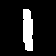

In [17]:
cv2_imshow(mX_train[14]*255)

In [18]:
vgg = VGG16()
vgg.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [19]:
vggpart=Sequential()
for i,layer in enumerate(vgg.layers):
  if i<19:
    vggpart.add(layer)

vggpart.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
print(len(vggpart.layers))

18


In [20]:
mnist_model = Sequential()
inputs = Input((None,None,1))
mnist_model.add(inputs)
mnist_model.add(Conv2D(64, (3,3), strides=1, padding="same"))
mnist_model.add(Conv2D(128, (3,3), strides=1, padding="same"))

for i,layer in enumerate(vggpart.layers):
  if i>5:
    layer.trainable=False
    mnist_model.add(layer)

mnist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                  295168    
_________________________________________________________________
block3_conv2 (Conv2D)        multiple                  590080    
_________________________________________________________________
block3_conv3 (Conv2D)        multiple                  590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block4_conv1 (Conv2D)        multiple                 

In [21]:
mnist_model.add(Conv2DTranspose(512, (3,3), strides=2, padding="same"))
mnist_model.add(LeakyReLU(alpha=0.2))
mnist_model.add(BatchNormalization(axis=-1))

mnist_model.add(Conv2DTranspose(256, (3,3), strides=2, padding="same"))
mnist_model.add(LeakyReLU(alpha=0.2))
mnist_model.add(BatchNormalization(axis=-1))

mnist_model.add(Conv2DTranspose(128, (3,3), strides=2, padding="same"))
mnist_model.add(LeakyReLU(alpha=0.2))
mnist_model.add(BatchNormalization(axis=-1))

mnist_model.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
mnist_model.add(LeakyReLU(alpha=0.2))
mnist_model.add(BatchNormalization(axis=-1))

mnist_model.add(Conv2DTranspose(1, (3, 3), padding="same"))

mnist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                  295168    
_________________________________________________________________
block3_conv2 (Conv2D)        multiple                  590080    
_________________________________________________________________
block3_conv3 (Conv2D)        multiple                  590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block4_conv1 (Conv2D)        multiple                 

In [22]:
mnist_model.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
#train the model
m_history = mnist_model.fit(
	mX_train, mX_train,
	validation_data=(mX_test, mX_test),
	epochs=10, batch_size=10, shuffle=True)

Epoch 1/10
 343/6000 [>.............................] - ETA: 8:35 - loss: 1461.0996 - accuracy: 0.7377

KeyboardInterrupt: ignored

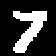

In [ ]:
preview_mnist = mX_test[34]
cv2_imshow(preview_mnist*255)

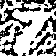

In [ ]:
test_mnist = np.reshape(mX_test[34], (1,56,56,1))
output_mnist = mnist_model.predict(test_mnist)
predicted_mnist = np.reshape(output_mnist,(56,56,1))*255
cv2_imshow(predicted_mnist)

In [ ]:
inputs = Input((None,None,3))
autoencoder = Sequential()
autoencoder.add(inputs)

#autoencoder.add(Conv2DTranspose(3, (3,3), strides=2, padding="same"))
autoencoder.add(Conv2D(3, (3,3), strides=1, padding="same"))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 3)     84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i,layer in enumerate(vggpart.layers):
  if i<15:layer.trainable=False
  else:layer.trainable=True
  autoencoder.add(layer)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 3)     84        
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                 

In [ ]:
print(len(autoencoder.layers))

19


In [ ]:
for i in range(14,18):
  layer = mnist_model.layers[i]
  layer.trainable=False
  autoencoder.add(layer)

autoencoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2DTranspose(128, (3,3), strides=1, padding="same"))
autoencoder.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
autoencoder.add(Conv2DTranspose(3, (3,3), strides=1, padding="same"))
autoencoder.add(Conv2DTranspose(1, (3,3), strides=1, padding="same"))
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 3)     84        
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                 

In [ ]:
autoencoder.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error",metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "data"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(320,256),
	class_mode='categorical',
  batch_size=64
)

In [ ]:
#train the model
history = autoencoder.fit(
	train_X, train_X,
	validation_data=(test_X, test_X),
	epochs=100)

Epoch 1/100
2/2 [==============================] - 11s 3s/step - loss: 349.1470 - val_loss: 91.2069
Epoch 2/100
2/2 [==============================] - 1s 605ms/step - loss: 78.7482 - val_loss: 68.6525
Epoch 3/100
2/2 [==============================] - 1s 598ms/step - loss: 60.5271 - val_loss: 41.2397
Epoch 4/100
2/2 [==============================] - 1s 609ms/step - loss: 41.2059 - val_loss: 35.0500
Epoch 5/100
2/2 [==============================] - 1s 602ms/step - loss: 32.7145 - val_loss: 28.1419
Epoch 6/100
2/2 [==============================] - 1s 611ms/step - loss: 24.8653 - val_loss: 19.0111
Epoch 7/100
2/2 [==============================] - 1s 606ms/step - loss: 17.5483 - val_loss: 15.9826
Epoch 8/100
2/2 [==============================] - 1s 609ms/step - loss: 15.2133 - val_loss: 14.4834
Epoch 9/100
2/2 [==============================] - 1s 612ms/step - loss: 13.5452 - val_loss: 9.3374
Epoch 10/100
2/2 [==============================] - 1s 607ms/step - loss: 8.9174 - val_loss: 

In [ ]:
autoencoder.save('vgg_autoencoder.h5')

In [ ]:
def draw_grid(out):
  res=out.shape
  plt.imshow(out, cmap = "PiYG_r")
  plt.clim(0.0, 1.0)
  plt.gca().set_xticks(np.arange(-.5, res[1], 2), minor = True)
  plt.gca().set_yticks(np.arange(-.5, res[0], 2), minor = True)
  plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
  plt.colorbar()
  plt.show()

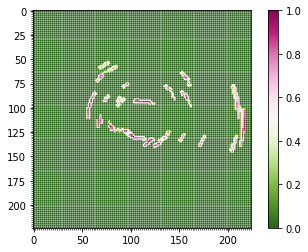

In [ ]:
out = train_list[10]
draw_grid(out)

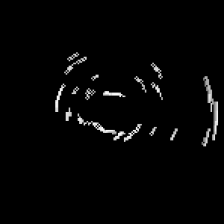

In [ ]:
testgrid = train_list[10]*255
cv2_imshow(testgrid)
resized = cv2.resize(testgrid, (150,150), interpolation = cv2.INTER_AREA)
rescaled=resized/255.0

In [ ]:
tester = np.reshape(train_list[10], (1,224,224,1))
print(tester.shape)

(1, 224, 224, 1)


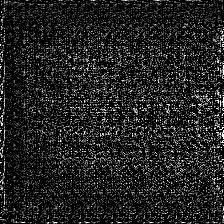

In [ ]:
outputgrid = autoencoder.predict(tester)
predicted = np.reshape(outputgrid,(224,224,1))*255
cv2_imshow(predicted)
presized = cv2.resize(predicted, (150,150), interpolation = cv2.INTER_AREA)
rescaled=resized/255.0